In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import numpy as np
from shapely.geometry import LineString
import math
import folium
from pyproj import CRS
from pyproj import Transformer

In [2]:
data = pd.read_csv('kjornes.csv', sep=';')


In [3]:
df = data

In [4]:
def transformer(x, y):
    transformer = Transformer.from_crs(5973, 4326)
    trans_x, trans_y =  transformer.transform(x, y)
    return trans_x, trans_y

In [5]:
z = df['Z'].tolist()
m = df['M'].tolist()
h = []
#Rekner ut hellinger, litt uelegant utanfor pandas, men funker..
for i in range(len(z)):
    h.append((z[i] - z[i -1])/(m[i] - m[i - 1]))    

In [6]:
#Lager pandas kolonne med hellinger
df['H'] = h
#Lager pandas kolonne med hellinger i grader
df['deg'] = np.degrees(np.arctan(df['H']))
#df['coord'] = list(zip(df.X, df.Y))
#list1 = []
#for i in range(len(df.X)):
#    x, y = transformer(df.X[i], df.Y[i])
#    list1.append((x, y))
#df['trans'] = list1


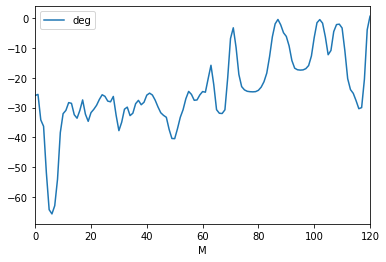

In [7]:
#Plotter helling på skredbane langs skredbana
df.plot('M', 'deg')

In [8]:
p = np.poly1d(np.polyfit(df['M'], df['Z'], 5))
print(p)
df['tilpass'] = p(df['M'])



            5             4             3           2
-2.475e-08 x + 7.439e-06 x - 0.0007957 x + 0.03919 x - 1.465 x + 159.6


In [9]:
z_tilpass = df['tilpass'].tolist()
h_tilpass = []
#Rekner ut hellinger, litt uelegant utanfor pandas, men funker..
for i in range(len(m)):
    h_tilpass.append((z_tilpass[i] - z_tilpass[i -1])/(m[i] - m[i - 1]))    
df['H_tilpass'] = h_tilpass
df['deg_tilpass'] = np.degrees(df['H_tilpass'])
df


,X,Y,Z,M,H,deg,tilpass,H_tilpass,deg_tilpass
0,78180.231043,6.812082e+06,159.0396,0,-0.486631,-25.948983,159.577454,-0.498945,-28.587436
1,78180.209043,6.812081e+06,158.5605,1,-0.479100,-25.599081,158.150973,-1.426481,-81.731334
2,78180.187143,6.812080e+06,157.8829,2,-0.677600,-34.121567,156.798202,-1.352770,-77.508040
3,78180.165143,6.812079e+06,157.1497,3,-0.733200,-36.248870,155.514632,-1.283570,-73.543156
4,78180.143143,6.812078e+06,155.8802,4,-1.269500,-51.772082,154.295925,-1.218707,-69.826795
...,...,...,...,...,...,...,...,...,...
116,78177.682143,6.811966e+06,101.6554,116,-0.586100,-30.374567,101.962253,-0.436381,-25.002781
117,78177.660143,6.811965e+06,101.0780,117,-0.577400,-30.002137,101.478824,-0.483429,-27.698434
118,78177.638243,6.811964e+06,100.7041,118,-0.373900,-20.500770,100.944214,-0.534610,-30.630912
119,78177.616243,6.811963e+06,100.6345,119,-0.069600,-3.981366,100.354120,-0.590094,-33.809899


In [10]:
x_topp = df['X'][0]
y_topp = df['Y'][0]
x_bunn = df['X'][df['M'].max()]
y_bunn = df['Y'][df['M'].max()]
latlon_topp = transformer(x_topp, y_topp)
latlon_bunn = transformer(x_bunn, y_bunn)

In [11]:
#Finner punkta med helling på 10 grader
df10 = df.loc[(df['deg_tilpass'] <= -9.8) & (df['deg_tilpass'] >= -10.2)]
df10

,X,Y,Z,M,H,deg,tilpass,H_tilpass,deg_tilpass
107,78177.879943,6.811975e+06,104.3835,107,-0.0804,-4.596693,104.638541,-0.172536,-9.885581


In [12]:
#Finner enkelpunktet på 10 grader
value = -23 #Verdien som skal finnest
mpos_10grad = abs(df['deg_tilpass'] - value).idxmin() #X-akse verdien, altså meterverdi langs skredbane
#mpos_10grad = 1044
zpos_10grad = df.loc[mpos_10grad, 'tilpass'] #Y-akse verdien, altså Z verdi (høgde) for 10 graders punkt
maxzpos = df['Z'].max() #Finner største Z verdi, høgast i skredbane
pos_topp = (0, df['tilpass'].max()) #Finner posisjonen til toppen av skredbane
pos_10grad = (mpos_10grad, zpos_10grad) #Finner posisjonen til 10 graderspunkt


In [13]:
#Lager til enkeltposisjoner for enklere utrekning
m1 = pos_topp[0] 
z1 = pos_topp[1]

m2 = pos_10grad[0]
z2 = pos_10grad[1]

z = z2 - z1
m = m2 - m1

#Finner betavinkel
beta = math.atan(z/m)
beta_deg = math.degrees(beta)
#Rekner ut alphavinkel
alpha = (0.77 * beta_deg) + -3.9
alpha_rad = math.radians(alpha)

#alpha_1sd = (0.96 * beta_deg) - 

m_max = df['M'].max()
temp_z = math.tan(alpha_rad) * m_max
pos_max = (m_max, z1 - -temp_z)

#Bruker Shapelybibliotek for å finne 
first_line = LineString(np.column_stack((df['M'], df['tilpass'])))
second_line = LineString(np.column_stack(([pos_topp[0], pos_max[0]], [pos_topp[1], pos_max[1]])))
intersection = first_line.intersection(second_line)
print(intersection)

koordliste = [(p.x, p.y) for p in intersection]

utlop = koordliste[-1]
#utlop = (intersection.x, intersection.y)
#print(utlop)
print(m2)

MULTIPOINT (0 159.5774537977283, 94.91519712322817 106.252795785339)
74


Text(0.05, 0.95, '$\\alpha=29$\n$\\beta=33$')

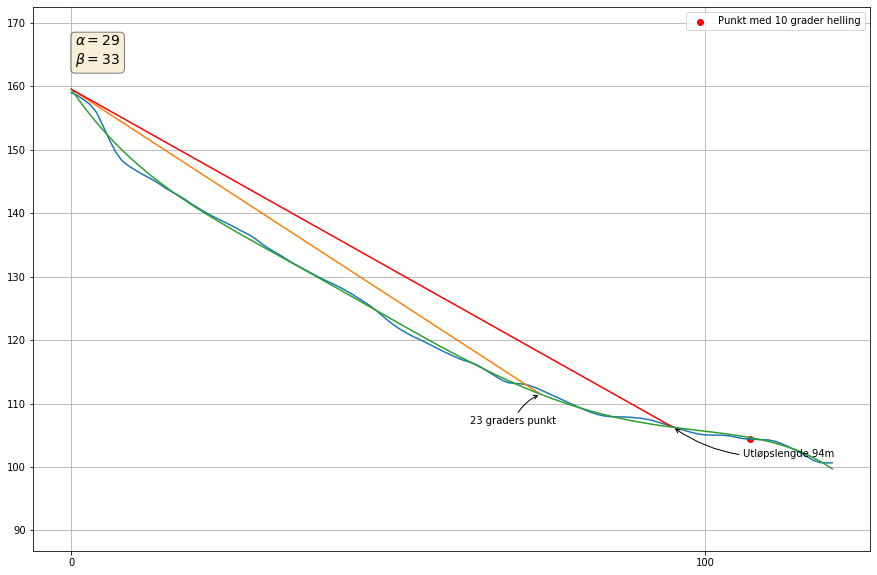

In [14]:
textstr = '\n'.join((
    r'$\alpha=%.f$' % (abs(int(alpha)), ),
    r'$\beta=%.f$' % (abs(int(beta_deg)), ),))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df['M'], df['Z']) #Høgdeprofilet
ax.scatter(df10['M'], df10['Z'], color='r', linewidth='1', label='Punkt med 10 grader helling') # 10 graders punkter
ax.plot([pos_topp[0], pos_10grad[0]], [pos_topp[1], pos_10grad[1]]) #Beta 
#ax.plot([pos_topp[0], pos_max[0]], [pos_topp[1], pos_max[1]])
ax.plot(*LineString(intersection).xy, color='red')
ax.plot(df['M'], p(df['M'])) #Plotter regresjonslinje ax2 + bx + c
ax.legend()
ax.grid()
loc = ticker.MultipleLocator(base=100.0)
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.axis('equal')
ax.annotate("23 graders punkt", xy=(m2, z2),  xycoords='data',
            xytext=(-70, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
ax.annotate("Utløpslengde "+str(int(utlop[0]))+'m', xy=utlop,  xycoords='data',
            xytext=(70, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

In [15]:
def transformer(x, y):
    transformer = Transformer.from_crs(5973, 4326)
    trans_x, trans_y =  transformer.transform(x, y)
    return trans_x, trans_y

In [16]:
print(utlop[0])
utlopint = int(utlop[0])
print(utlopint)
coordinatx = df['X'][utlopint]
coordinaty = df['Y'][utlopint]
print(coordinatx)

94.91519712322817
94
78178.16554295085


In [17]:
transformer = Transformer.from_crs(5973, 4326)
trans_x, trans_y =  transformer.transform(coordinatx, coordinaty)

In [18]:
#Lager kartvisning for å verifisere at koordinater er for riktig stad
m = folium.Map(location=[latlon_bunn[0], latlon_bunn[1]], zoom_start=15) #Bruker transformerte koordinater (ikkej funne ut korleis bruke UTM med folium)
folium.PolyLine([latlon_topp, latlon_bunn], color="red", weight=2.5, opacity=1).add_to(m)
folium.Circle(
    radius=1,
    location=[trans_x, trans_y],
    fill=False,
).add_to(m)
#Legger til Norgeskart WMS
folium.raster_layers.WmsTileLayer(
    url='https://opencache.statkart.no/gatekeeper/gk/gk.open_gmaps?layers=topo4&zoom={z}&x={x}&y={y}',
    name='Norgeskart',
    fmt='image/png',
    layers='topo4',
    attr=u'<a href="http://www.kartverket.no/">Kartverket</a>',
    transparent=True,
    overlay=True,
    control=True,
    
).add_to(m)

#folium.LayerControl().add_to(m)

m